In [1]:
from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

base_dir: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
Parameters(
  sentence_length_outlier = [0, 1, 2, 181, 252]
  bigram_window_size = 15
  bigram_max_rank = None
  stopword_list = ['financial', 'market', 'federal', 'bank', 'banking', 'bankers', 'speech', 'bi', 'review', 'year', 'reserve', 'policy', 'state', 'central', 'board', 'percent', 'rate', 'mr', 'alan', 'greenspan', 'ben', 'bernanke', 'janet', 'yellen', 'jerome', 'powell', 'vol', 'ha', 'wa', 'ii']
  ws_quarterly = 4
  ws_semiannually = 2
  ws_annually = 1
  strength_alpha = 0.9
  base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
  data_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data
  output_base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output
  bis_raw_pkl_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/bis_w_content_FINAL.pkl
  fred_gdp_quarterly_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/fred_g

In [43]:
fred_gdp_quarterly_csv_filepath = parameters.fred_gdp_quarterly_csv_filepath 
fred_gdp_semiannually_csv_filepath  = parameters.fred_gdp_semiannually_csv_filepath  
fred_gdp_annually_csv_filepath  = parameters.fred_gdp_annually_csv_filepath  

output_base_dir = parameters.output_base_dir
fred_gdp_index_dict_pkl_filepath = os.path.join(output_base_dir, 'fred_gdp_index_dict.pkl')

fred_index_filepath_dict = {'quarterly': fred_gdp_quarterly_csv_filepath, 'semiannually': fred_gdp_semiannually_csv_filepath, 'annually': fred_gdp_annually_csv_filepath}
def get_index_dict(fred_gdp_index_dict_pkl_filepath, fred_index_filepath_dict):
    if os.path.exists(fred_gdp_index_dict_pkl_filepath):
        index_dict = load_pkl(fred_gdp_index_dict_pkl_filepath)
    else:
        index_dict = dict()

        for period_category, index_data_filepath in fred_index_filepath_dict.items():
            index_dict[period_category] = dict()

            f = open(index_data_filepath, 'r', encoding='utf-8')
            rdr = csv.reader(f)
            firstline = True
            for line in rdr:
                if firstline:
                    firstline = False
                    continue
                _period = line[0]
                if _period == '':
                    continue
                _val = line[1]
                index_dict[period_category][_period] = _val
            f.close()

        end_pkl(index_dict, fred_gdp_index_dict_pkl_filepath)
    return index_dict
fred_index_dict = get_index_dict(fred_gdp_index_dict_pkl_filepath, fred_index_filepath_dict)

Creating .pkl completed:  /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/fred_gdp_index_dict.pkl


In [45]:
fred_index_dict['annually'].keys()

dict_keys(['1999_', '2000_', '2001_', '2002_', '2003_', '2004_', '2005_', '2006_', '2007_', '2008_', '2009_', '2010_', '2011_', '2012_', '2013_', '2014_', '2015_', '2016_', '2017_', '2018_', '2019_'])

In [47]:
bigram_uniqueness_strength_pkl_filepath = os.path.join(output_base_dir, 'bigram-emerging_topic_score-strength_20191102-02-20-26.pkl')
bigram_uniqueness_strength_dict = load_pkl(bigram_uniqueness_strength_pkl_filepath)

period_dict = {'quarterly': list(), 'semiannually': list(), 'annually': list()}
proposed_data_dict = {'quarterly': list(), 'semiannually': list(), 'annually': list()}
fred_data_dict = {'quarterly': list(), 'semiannually': list(), 'annually': list()}

for _period_category, _period_dict in bigram_uniqueness_strength_dict.items():
    data_of_previous_period = None
    for _period in sorted(_period_dict.keys()): 
        count = 0
        _sum_product = 0
        for _bigram, (_freq, _emerging_topic_score, _strength) in sorted(_period_dict[_period].items(),
                                                               key=lambda t: t[-1][0],
                                                               reverse=True):  # CONTROL PRINTING ORDER
            count += 1
            _sum_product += (_emerging_topic_score*_strength)
            if count == 5:
                if data_of_previous_period is None:
                    data_of_previous_period = -_sum_product
                    continue
                period_dict[_period_category].append(_period)
                proposed_data_dict[_period_category].append(data_of_previous_period)
                fred_data_dict[_period_category].append(float(fred_index_dict[_period_category][_period]))
                data_of_previous_period = -_sum_product
                break

In [48]:
plt.rcParams["figure.figsize"] = (20,5)

def rescale_(values, scaler):
    values = values.reshape((len(values), 1))
    # train the standardization
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    return normalized

In [49]:
# x = np.array(fred_data_dict['quarterly'])
# y = np.array(proposed_data_dict['quarterly'])

# plt.plot(x,'r', label='Real GDP (Percent Change)')
# plt.xticks(list(range(len(period_dict['quarterly']))), period_dict['quarterly'], rotation='vertical')
# plt.legend()

# plt.plot(y, 'g', label='-(emerging_topic_score * strength)')
# plt.xticks(list(range(len(period_dict['quarterly']))), period_dict['quarterly'], rotation='vertical')
# plt.legend()

In [68]:
from dtw import dtw
l2_norm = lambda x, y: (x - y) ** 2

In [97]:
std_scaler = StandardScaler()
def show_plt_chart(scaler, _period_category):
    x = np.array(fred_data_dict[_period_category])
    y = np.array(proposed_data_dict[_period_category])

    x_normalized = rescale_(x, scaler)
    y_normalized = rescale_(y, scaler)

    plt.plot(x_normalized,'r', label='standardized: Real GDP (Percent Change)')
    plt.plot(y_normalized, 'g', label='standardized: -(emerging_topic_score * strength)')
    plt.xticks(list(range(len(period_dict[_period_category]))), period_dict[_period_category], rotation='vertical')
    plt.grid()
    plt.legend()
    
    dist, cost_matrix, acc_cost_matrix, path = dtw(x_normalized, y_normalized, dist=l2_norm)
    print('dist: ', dist)

/home/dmlab/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


dist:  2.148315895220191


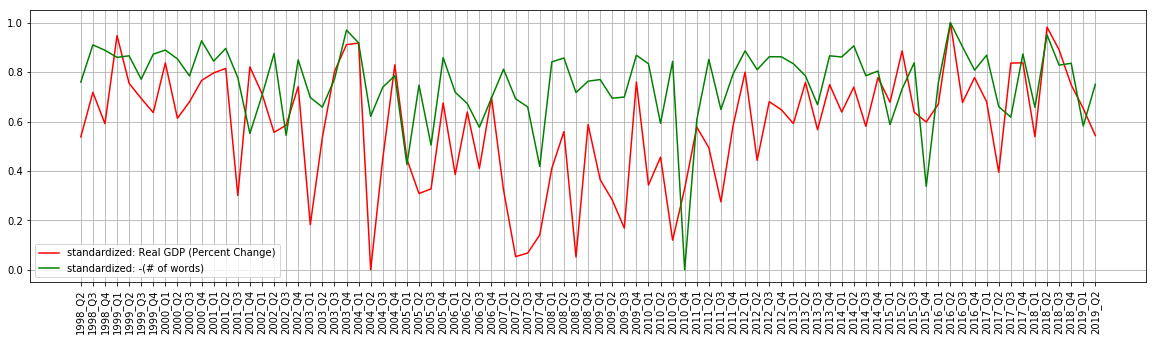

In [117]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
_period_category = 'quarterly'
words_quarterly = [-678	,-442	,-608	,-141	,-394	,-474	,-549	,-286	,-579	,-492	,-379	,-339	,-315	,-988	,-307	,-448	,-654	,-616	,-411	,-1143	,-681	,-332	,-189	,-181	,-1382	,-794	,-296	,-796	,-978	,-953	,-498	,-877	,-546	,-845	,-467	,-959	,-1312	,-1293	,-1197	,-844	,-650	,-1314	,-612	,-904	,-1012	,-1161	,-387	,-933	,-785	,-1225	,-951	,-626	,-735	,-1022	,-620	,-335	,-802	,-491	,-534	,-607	,-389	,-640	,-401	,-546	,-414	,-622	,-364	,-494	,-222	,-547	,-599	,-504	,-73	,-496	,-364	,-492	,-865	,-287	,-285	,-677	,-96	,-217	,-402	,-527	,-671]
x_ = np.array(words_quarterly)
x_normalized = rescale_(x_, minmax_scaler)

y_ = np.array(proposed_data_dict[_period_category])
y_normalized = rescale_(y_, minmax_scaler)

plt.plot(x_normalized,'r', label='standardized: Real GDP (Percent Change)')
plt.plot(y_normalized, 'g', label='standardized: -(# of words)')
plt.xticks(list(range(len(period_dict[_period_category]))), period_dict[_period_category], rotation='vertical')
plt.grid()
plt.legend()

dist, cost_matrix, acc_cost_matrix, path = dtw(x_normalized, y_normalized, dist=l2_norm)
print('dist: ', dist)

dist:  40.34063988579984


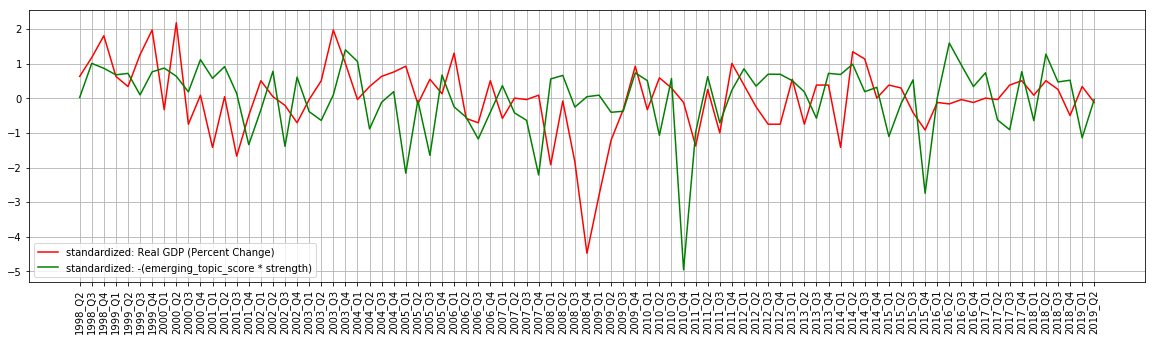

In [98]:
show_plt_chart(std_scaler, 'quarterly')

dist:  20.005088007160907


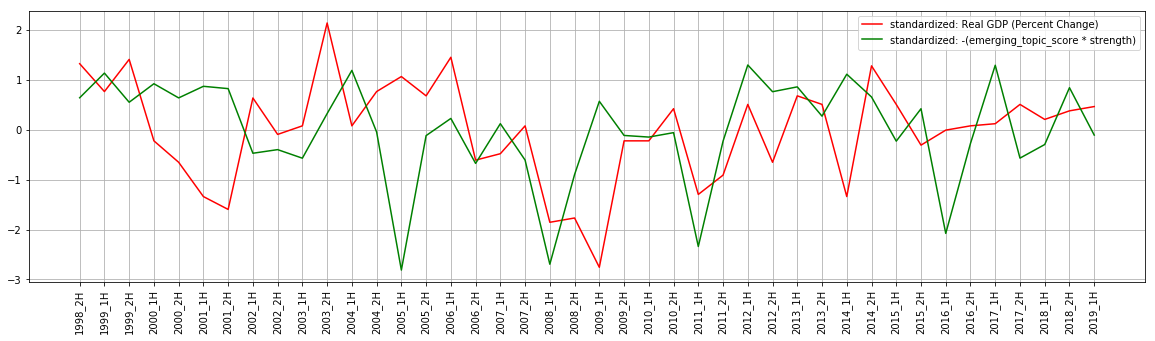

In [71]:
show_plt_chart(std_scaler, 'semiannually')

dist:  8.55671503363866


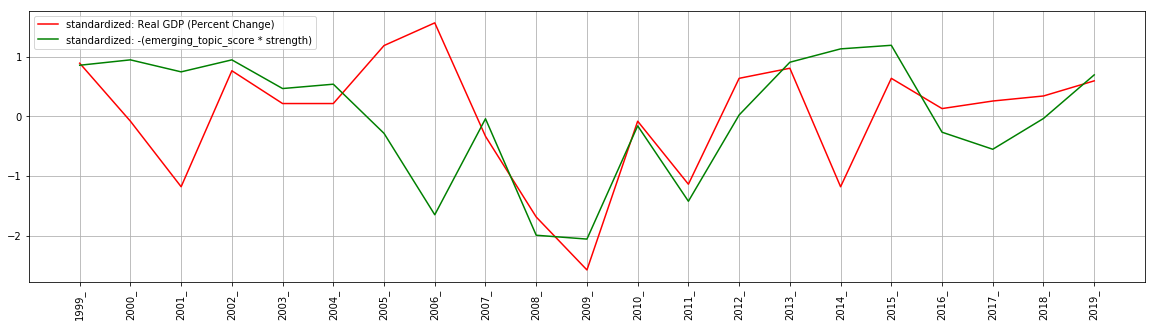

In [72]:
show_plt_chart(std_scaler, 'annually')

In [102]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

dist:  1.0259727099584968


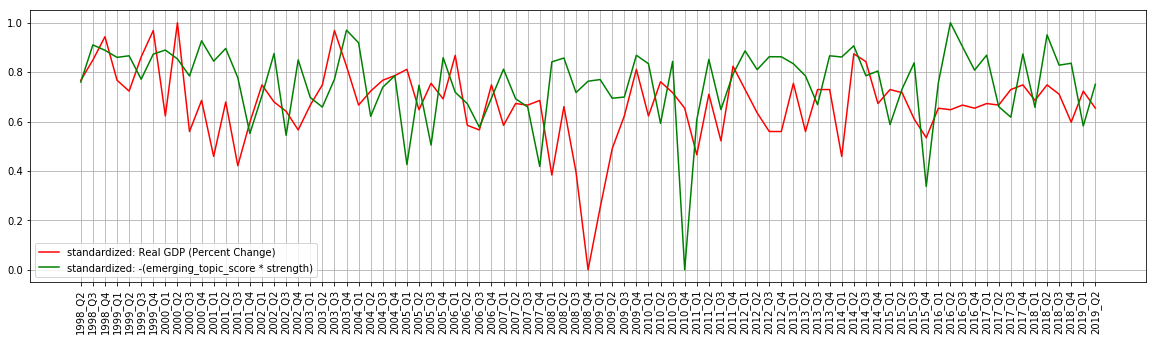

In [73]:
show_plt_chart(minmax_scaler, 'quarterly')

dist:  1.0813901684468348


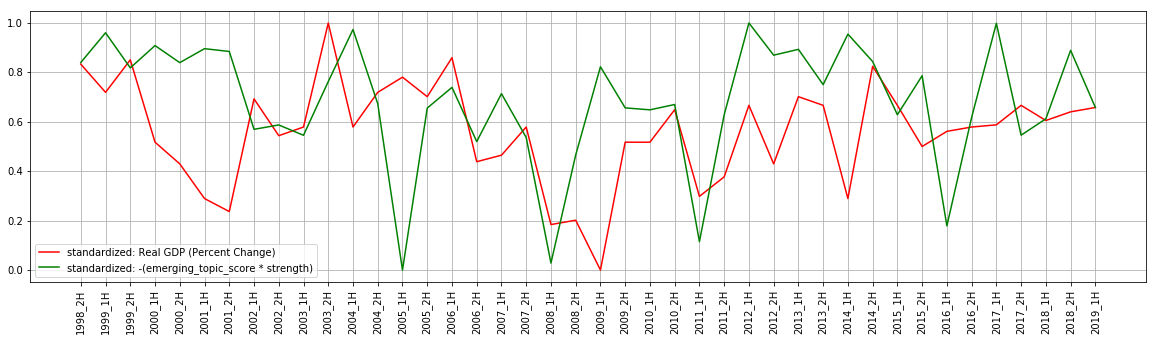

In [74]:
show_plt_chart(minmax_scaler, 'semiannually')

dist:  0.598415146224261


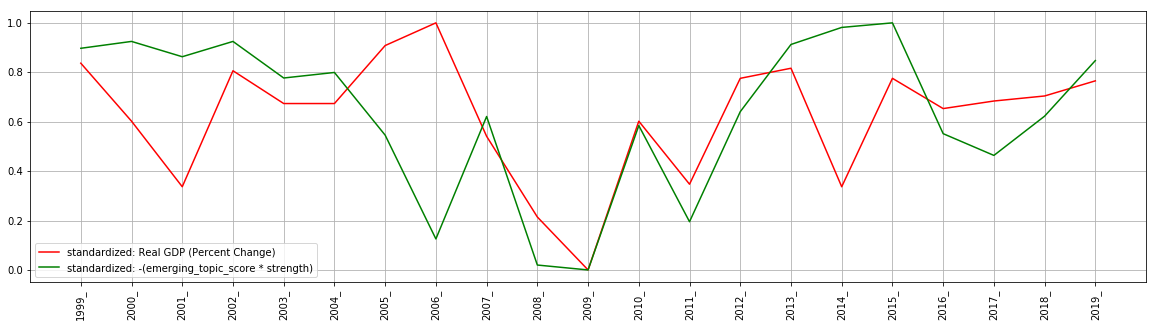

In [75]:
show_plt_chart(minmax_scaler, 'annually')

In [9]:


dist, cost_matrix, acc_cost_matrix, path = dtw(x_normalized, y_normalized, dist=l2_norm)
print(dist)

40.34063988579984


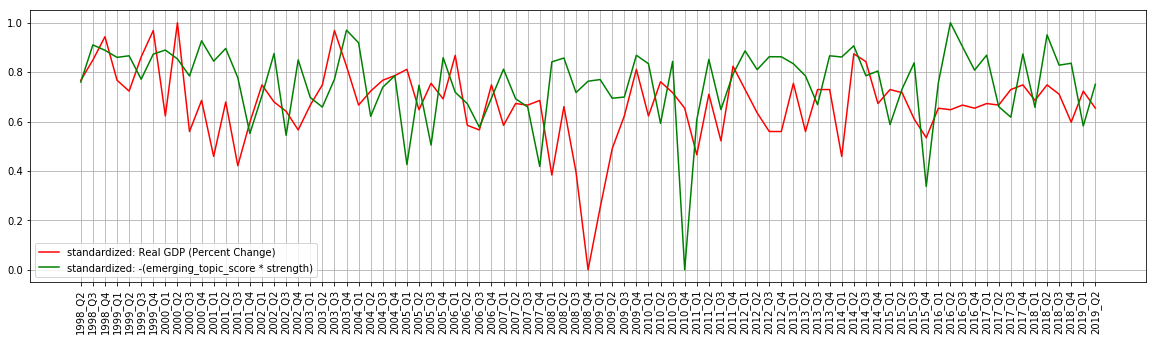

In [31]:


x_normalized = rescale_(x, scaler)
y_normalized = rescale_(y, scaler)

plt.plot(x_normalized,'r', label='standardized: Real GDP (Percent Change)')
plt.plot(y_normalized, 'g', label='standardized: -(emerging_topic_score * strength)')
plt.xticks(list(range(len(period_dict['quarterly']))), period_dict['quarterly'], rotation='vertical')
plt.grid()
plt.legend()

In [25]:
dist, cost_matrix, acc_cost_matrix, path = dtw(x_normalized, y_normalized, dist=l2_norm)
print(dist)

1.0259727099584968


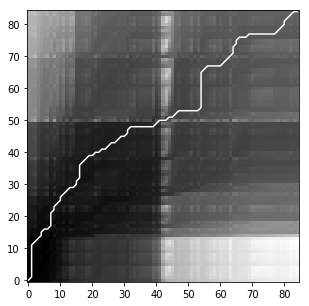

In [26]:
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [27]:
path[0][1]

1

In [29]:
# plt.plot(x, 'bo-' ,label='x')
# plt.plot(y, 'g^-', label = 'y')
# plt.legend();
# for i in range(len(path[0])):
#     map_x , map_y = path[0][i], path[1][i]
#     #print map_x, x[map_x], ":", map_y, y[map_y]
    
#     plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')